In [ ]:
#conda create --name FINE_TUNING_LLM python=3.12.4
#conda activate FINE_TUNING_LLM
#conda install -n FINE_TUNING_LLM ipykernel --update-deps --force-reinstall

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
# You only need to run this once per machine
!pip install bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/accelerate.git
!pip install datasets scipy ipywidgets matplotlib

In [ ]:
!pip install sentencepiece
!pip install protobuf

In [1]:
import torch
torch.__version__

'2.3.1+cu118'

In [1]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='notes.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='notes_validation.jsonl', split='train')
#print(train_dataset[0])

Support for third party widgets will remain active for the duration of the session. To disable support:


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [2]:
def formatting_func(example):
    text = f"### {example['note']}"
    return text

Here's another common one:

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [5]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/2197 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

2307


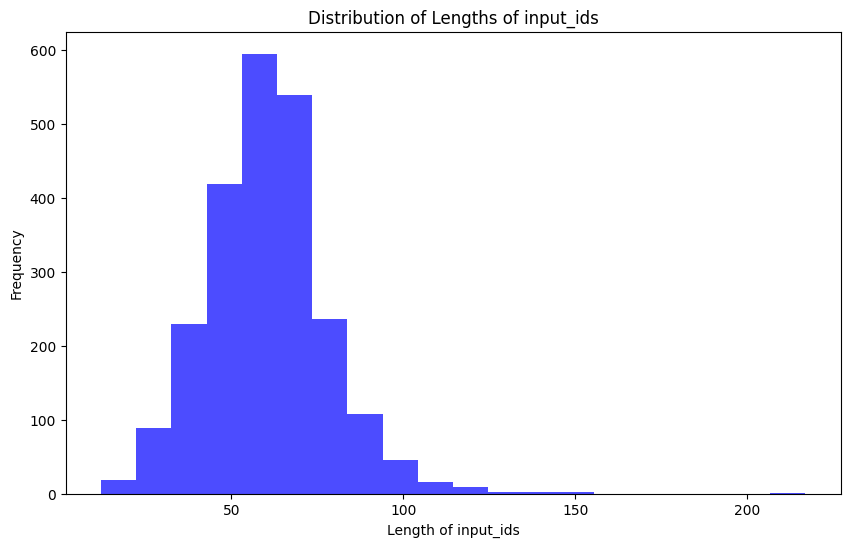

In [6]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [7]:
max_length = 256 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/2197 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1542, 19890, 3801, 1070, 18207, 29501, 29521, 8318, 1120, 1169, 18168, 2559, 4458, 13551, 5532, 1554, 23624, 1065, 18207, 29516, 29526, 3509, 1081, 8989, 10495, 29501, 29521, 4753, 21895, 781, 14417, 1811, 1903, 20650, 14091, 3624, 11292, 1070, 14429, 11516, 3380, 1761, 5073, 1507, 6977, 1056, 5903, 1072, 12981, 1065, 18884, 1052, 9871, 29491, 11141, 1903, 20650, 1761, 5012, 5360, 21965, 1072, 2355, 26162, 29491, 2]


Now all the samples should be the same length, `max_length`.

2307


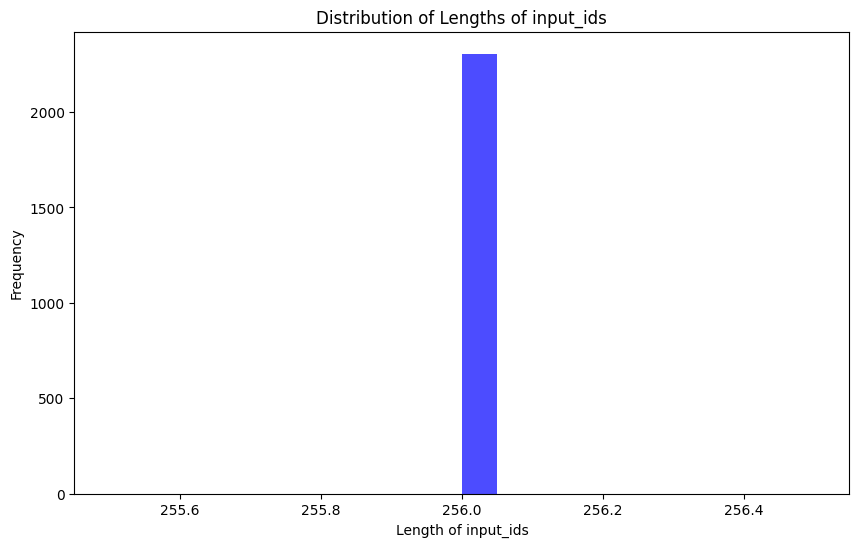

In [16]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

Optionally, you can check how Mistral does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

In [10]:
eval_prompt = """ Name 3 new technologies in Logging and Perforation
###### Answer :
"""

The `eval_prompt` I used was:

In [11]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\yxzhh\AppData\Roaming\Python\Python312\site-packages\transformers\models\mistral\modeling_mistral.py:647: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Name 3 new technologies in Logging and Perforation
###### Answer :

1. **Electronic logging devices (ELDs)** are electronic systems that record a driver's hours of service (HOS) information, including the date, time, location, engine hours, vehicle miles driven, and other data. ELDs help ensure compliance with HOS regulations by automatically recording driving time and preventing drivers from falsifying their logs.
2. **Perforating guns** are specialized tools used to create perforations in wellbores during drilling operations. These guns use high-pressure water or air jets to create small holes in the rock formation, allowing for the injection of fluids such as cement or drilling mud into the formation.
3. **Smart perforators** are advanced perforating tools that can be remotely controlled and monitored using telemetry technology. They allow operators to adjust the firing sequence and depth of penetration in real-time, improving accuracy and reducing the risk of damage to the wellbore

Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [12]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [14]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85065728 || all params: 3843428352 || trainable%: 2.213277319342624


See how the model looks different now, with the LoRA adapters added:

In [16]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

### 5. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 20 minutes on the 1x A10G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting, you can try different checkpoint versions with different degrees of overfitting.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [17]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [18]:
from accelerate import Accelerator
# Initialize the accelerator
accelerator = Accelerator()

model = accelerator.prepare_model(model)

In [19]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=1500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=500,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=500,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\yxzhh\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


  0%|          | 0/1500 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\FINE_TUNING_LLM\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.8908, 'grad_norm': 18.962158203125, 'learning_rate': 2.4616154873164223e-05, 'epoch': 0.02}
{'loss': 2.5971, 'grad_norm': 9.855137825012207, 'learning_rate': 2.4198931909212282e-05, 'epoch': 0.05}
{'loss': 2.529, 'grad_norm': 10.13984203338623, 'learning_rate': 2.3781708945260348e-05, 'epoch': 0.07}
{'loss': 2.4313, 'grad_norm': 8.192861557006836, 'learning_rate': 2.3364485981308414e-05, 'epoch': 0.09}
{'loss': 2.4519, 'grad_norm': 9.359848976135254, 'learning_rate': 2.2947263017356476e-05, 'epoch': 0.11}
{'loss': 2.3522, 'grad_norm': 9.675088882446289, 'learning_rate': 2.2530040053404542e-05, 'epoch': 0.14}
{'loss': 2.2756, 'grad_norm': 7.448574066162109, 'learning_rate': 2.2112817089452604e-05, 'epoch': 0.16}
{'loss': 2.4835, 'grad_norm': 8.285670280456543, 'learning_rate': 2.1695594125500667e-05, 'epoch': 0.18}
{'loss': 2.4054, 'grad_norm': 10.987030982971191, 'learning_rate': 2.1278371161548733e-05, 'epoch': 0.2}
{'loss': 2.3081, 'grad_norm': 9.691205978393555, 'learning

  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 2.135864496231079, 'eval_runtime': 18.7379, 'eval_samples_per_second': 5.87, 'eval_steps_per_second': 0.747, 'epoch': 0.45}


C:\Users\yxzhh\AppData\Roaming\Python\Python312\site-packages\peft\utils\save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
c:\ProgramData\anaconda3\envs\FINE_TUNING_LLM\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.3016, 'grad_norm': 8.440470695495605, 'learning_rate': 1.6271695594125503e-05, 'epoch': 0.48}
{'loss': 2.2732, 'grad_norm': 10.333203315734863, 'learning_rate': 1.585447263017357e-05, 'epoch': 0.5}
{'loss': 2.1742, 'grad_norm': 8.159846305847168, 'learning_rate': 1.5437249666221628e-05, 'epoch': 0.52}
{'loss': 2.3123, 'grad_norm': 7.440310955047607, 'learning_rate': 1.5020026702269693e-05, 'epoch': 0.55}
{'loss': 2.262, 'grad_norm': 7.5925374031066895, 'learning_rate': 1.4602803738317758e-05, 'epoch': 0.57}
{'loss': 2.1893, 'grad_norm': 7.50217342376709, 'learning_rate': 1.4185580774365822e-05, 'epoch': 0.59}
{'loss': 2.2997, 'grad_norm': 7.763234615325928, 'learning_rate': 1.3768357810413888e-05, 'epoch': 0.61}
{'loss': 2.1408, 'grad_norm': 8.378331184387207, 'learning_rate': 1.3351134846461948e-05, 'epoch': 0.64}
{'loss': 2.3418, 'grad_norm': 9.364808082580566, 'learning_rate': 1.2933911882510014e-05, 'epoch': 0.66}
{'loss': 2.2467, 'grad_norm': 7.610098838806152, 'learnin

  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.8801201581954956, 'eval_runtime': 18.4977, 'eval_samples_per_second': 5.947, 'eval_steps_per_second': 0.757, 'epoch': 0.91}


C:\Users\yxzhh\AppData\Roaming\Python\Python312\site-packages\peft\utils\save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
c:\ProgramData\anaconda3\envs\FINE_TUNING_LLM\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2208, 'grad_norm': 7.146160125732422, 'learning_rate': 7.927236315086784e-06, 'epoch': 0.93}
{'loss': 2.3002, 'grad_norm': 10.675107955932617, 'learning_rate': 7.510013351134847e-06, 'epoch': 0.96}
{'loss': 2.2749, 'grad_norm': 7.811581611633301, 'learning_rate': 7.092790387182911e-06, 'epoch': 0.98}
{'loss': 2.1707, 'grad_norm': 5.786709785461426, 'learning_rate': 6.675567423230974e-06, 'epoch': 1.0}
{'loss': 1.7638, 'grad_norm': 8.969910621643066, 'learning_rate': 6.258344459279039e-06, 'epoch': 1.02}
{'loss': 1.8112, 'grad_norm': 7.258237361907959, 'learning_rate': 5.841121495327103e-06, 'epoch': 1.05}
{'loss': 1.7777, 'grad_norm': 8.390810012817383, 'learning_rate': 5.423898531375167e-06, 'epoch': 1.07}
{'loss': 1.7933, 'grad_norm': 7.946865081787109, 'learning_rate': 5.006675567423231e-06, 'epoch': 1.09}
{'loss': 1.7064, 'grad_norm': 8.631255149841309, 'learning_rate': 4.589452603471296e-06, 'epoch': 1.11}
{'loss': 1.8455, 'grad_norm': 11.77323055267334, 'learning_rate'

  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.6919403076171875, 'eval_runtime': 18.5198, 'eval_samples_per_second': 5.94, 'eval_steps_per_second': 0.756, 'epoch': 1.36}


C:\Users\yxzhh\AppData\Roaming\Python\Python312\site-packages\peft\utils\save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'train_runtime': 2579.3316, 'train_samples_per_second': 1.163, 'train_steps_per_second': 0.582, 'train_loss': 2.1730856221516928, 'epoch': 1.36}


TrainOutput(global_step=1500, training_loss=2.1730856221516928, metrics={'train_runtime': 2579.3316, 'train_samples_per_second': 1.163, 'train_steps_per_second': 0.582, 'total_flos': 3.316134264491213e+16, 'train_loss': 2.1730856221516928, 'epoch': 1.364877161055505})

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-1500")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [3]:
eval_prompt = """ Name 3 new technologies in Logging and Perforation
###### Answer :
"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\yxzhh\AppData\Roaming\Python\Python312\site-packages\transformers\models\mistral\modeling_mistral.py:647: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Name 3 new technologies in Logging and Perforation
###### Answer :
    The three new technologies are:
1. Distributed fiber-optic sensing (DFOS) technology for real-time monitoring of wellbore conditions during hydraulic fracturing operations. This technology uses optical fibers embedded in the wellbore to measure temperature, pressure, strain, and other parameters that can provide insights into the behavior of the rock formation and the effectiveness of the hydraulic fracturing process.
2. High-pressure perforating technology for creating larger and more uniform perforations in hard formations. This technology involves using high-pressure nitrogen or carbon dioxide gas to create larger perforations with less damage to the surrounding rock.
3. Smart completion systems for optimizing hydraulic fracturing treatments. These systems use sensors and actuators to monitor and control the flow of fluids and proppants into the wellbore during hydraulic fracturing. They allow for real-time adjus

### Sweet... it worked! The fine-tuned model now prints out journal entries in my style!

The knowledge in Geoscience is largely increased!

I hope you enjoyed this tutorial on fine-tuning Mistral on your own data. If you have any questions!

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙